XAI methods for 3D segmentation

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys 

import torch

import torch.nn.functional as F
from captum.attr import LayerGradCam

import numpy as np 

import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(project_root)

from models import AttentionVNet, VNet
from lit_models import LitBaseVNet
from dataloader import ProstateDataModule, download_and_extract_msd_prostate

In [3]:
# get data

DATA_ROOT = "../data"
download_and_extract_msd_prostate(DATA_ROOT)

dm = ProstateDataModule(
    root_dir=DATA_ROOT, 
    batch_size=2,
    roi_size=(128, 128, 64),
    num_workers=10
)

[dataloader.py] Downloading: https://msd-for-monai.s3-us-west-2.amazonaws.com/Task05_Prostate.tar
[dataloader.py] Saved: ../data\Task05_Prostate.tar
[dataloader.py] Extracting tar to: ../data


In [13]:
# import model

checkpoint_path = "../checkpoints/best-attention-vnet-epoch=08-val_dice=0.417.ckpt"
model = LitBaseVNet.load_from_checkpoint(
    checkpoint_path, 
    model_obj=AttentionVNet(in_ch=2, out_ch=3, base_channels=16)
)
model.eval()
# model.cuda()


class xai_wrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        return out.sum(dim=(2, 3, 4))
    
wrapper_model = xai_wrapper(model)

# select target layer (last conv 3d layer)
target_layer = model.model.output_conv

c:\Users\janis\miniconda3\envs\def\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.6, which is newer than your current Lightning version: v2.5.5


In [14]:
# Grad cam init
lgc = LayerGradCam(wrapper_model, target_layer)

In [16]:
# Input tensor

dm.setup(stage="fit")
batch = next(iter(dm.val_dataloader()))

x, y = model._prepare_batch(batch)
# x = x.cuda()

input_tensor = x
input_tensor.requires_grad = True

target_class = 1 # 0 - background, 1 - PZ ,2 - TZ 

attributions = lgc.attribute(input_tensor, target=target_class, relu_attributions=True)

print(f"Activation map size: {attributions.shape}")

c:\Users\janis\miniconda3\envs\def\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)
c:\Users\janis\miniconda3\envs\def\Lib\site-packages\torch\utils\data\dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

Activation map size: torch.Size([1, 1, 128, 128, 35])


In [17]:
# Interpolation to input size for visualisation
spatial_shape = input_tensor.shape[2:] # get spatial dimension, leave batch and channels
attributions_upsample = LayerGradCam.interpolate(attributions, spatial_shape, interpolate_mode='trilinear')
heatmap_3d = attributions_upsample.squeeze().cpu().detach().numpy()

heatmap_min = heatmap_3d.min()
heatmap_max = heatmap_3d.max()
heatmap_norm = (heatmap_3d - heatmap_min) / (heatmap_max - heatmap_min + 1e-8)
# find layer with most intense gradient heatmap_norm = (heatmap_3d - heatmap_min) / (heatmap_max - heatmap_min + 1e-8)

In [ ]:
# find layer with most intense gradient 
original_image = input_tensor[0, 0, :, :, :].cpu().detach().numpy()

# 1. Axial (axis 0)
axial_sums = np.sum(heatmap_3d, axis=(1, 2)) 
i_max_axial = np.argmax(axial_sums)
axial_slice_heatmap = heatmap_3d[i_max_axial, :, :]
axial_slice_image = original_image[i_max_axial, :, :]

# 2. Coronal (axis 1)
coronal_sums = np.sum(heatmap_3d, axis=(0, 2)) 
i_max_coronal = np.argmax(coronal_sums)
coronal_slice_heatmap = heatmap_3d[:, i_max_coronal, :]
axial_slice_image = original_image[:, i_max_coronal , :]

# 3. Sagittal (axis 2)
sagittal_sums = np.sum(heatmap_3d, axis=(0, 1)) 
i_max_sagittal = np.argmax(sagittal_sums)
sagittal_slice_heatmap = heatmap_3d[:, :, i_max_sagittal]
axial_slice_image = original_image[:, : , i_max_sagittal]

In [ ]:
# # Find slices with the most intense gradient to visualize

# # Extract the original input image for background
# original_image = input_tensor[0, 0, :, :, :].cpu().detach().numpy()

# # 1. Axial (axis 0 corresponds to depth)
# axial_sums = np.sum(heatmap_norm, axis=(1, 2)) 
# i_max_axial = np.argmax(axial_sums)


# heatmap_axial = heatmap_norm[i_max_axial, :, :]
# image_axial = original_image[i_max_axial, :, :]

# # 2. Coronal (axis 1 corresponds to Height)
# coronal_sums = np.sum(heatmap_norm, axis=(0, 2)) 
# i_max_coronal = np.argmax(coronal_sums)

# heatmap_coronal = heatmap_norm[:, i_max_coronal, :]
# image_coronal = original_image[:, i_max_coronal, :]

# # 3. Sagittal (axis 2 in cotrsponds to Width)
# sagittal_sums = np.sum(heatmap_norm, axis=(0, 1)) 
# i_max_sagittal = np.argmax(sagittal_sums)

# heatmap_sagittal = heatmap_norm[:, :, i_max_sagittal]
# image_sagittal = original_image[:, :, i_max_sagittal]

# print(f"Selected slices - Axial: {i_max_axial}, Coronal: {i_max_coronal}, Sagittal: {i_max_sagittal}")

Selected slices - Axial: 63, Coronal: 52, Sagittal: 25


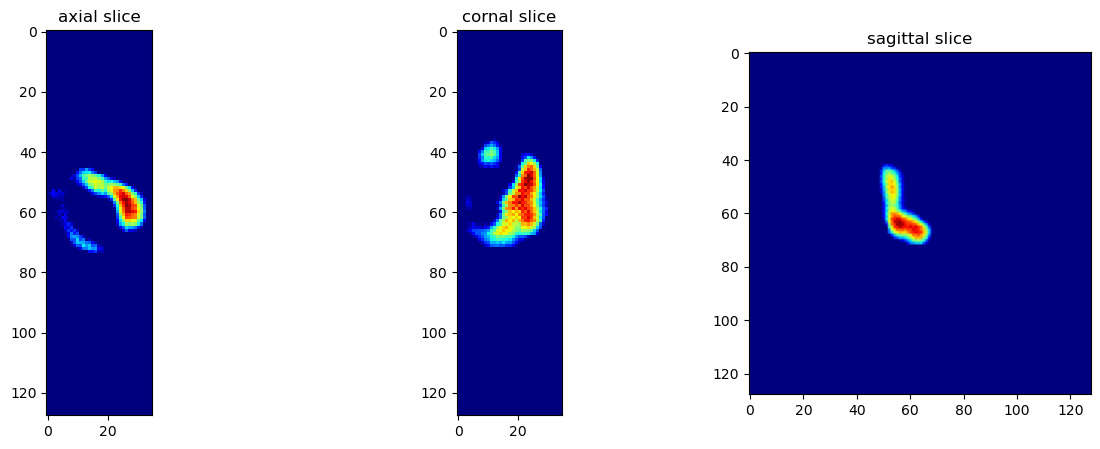

In [ ]:
# visu orginal slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(axial_slice_heatmap, cmap = 'jet')
axes[0].set_title('axial slice')

axes[1].imshow(coronal_slice_heatmap, cmap = 'jet')
axes[1].set_title('cornal slice')

axes[2].imshow(sagittal_slice_heatmap, cmap = 'jet')
axes[2].set_title('sagittal slice')

# visu attention
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(axial_slice_heatmap, cmap = 'jet')
axes[0].set_title('axial slice heatmap')

axes[1].imshow(coronal_slice_heatmap, cmap = 'jet')
axes[1].set_title('cornal slice heatmap')

axes[2].imshow(sagittal_slice_heatmap, cmap = 'jet')
axes[2].set_title('sagittal slice heatmap')

plt.show()